In [1]:
import numpy as np
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models

from analysis_utils import generate_classification_report, plot_roc_curve, plot_train_loss_accuracy
from data_loader import load_data
from matplotlib import pyplot as plt
from model_utils import train_model, test_model

Class Indices: {'Benign': 0, 'Malignant': 1}
Number of Training Samples: 9503
Number of Validation Samples: 2376
Number of Test Samples: 2000


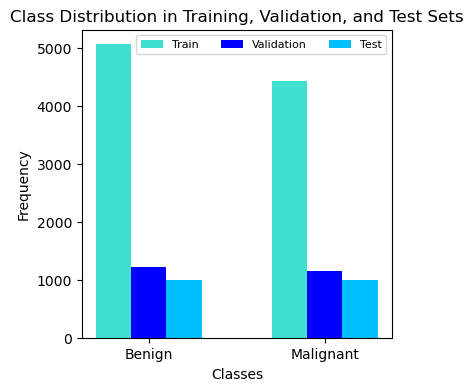

In [2]:
# load data
train_loader, val_loader, test_loader, class_names = load_data(batch_size=32)

### Model Definitions

In [3]:
class UNetForClassification(nn.Module):
    """
    
    """

    def __init__(self, encoder_name='resnet34', n_classes=2):
        super(UNetForClassification, self).__init__()
        self.encoder_name = encoder_name
        self.n_classes = n_classes
        # initialize U-Net model with specified encoder
        self.unet = smp.Unet(encoder_name=self.encoder_name, encoder_weights="imagenet", in_channels=3, classes=self.n_classes)
        # initialize adaptive average pooling layer, reducing the spatial dimensions to (1, 1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        # initialize linear layer with 2 output features for binary classification
        self.fc = nn.Linear(self.n_classes, 2)

    def forward(self, x):
        """
        
        """
        
        # pass input through encoder to extract features
        features = self.unet.encoder(x)
        # pass features through the decoder to reconstruct image
        decoder_output = self.unet.decoder(*features)
        # apply adaptive average pooling
        x = self.pool(decoder_output)
        # flatten tensor
        x = x.view(x.size(0), -1)
        # pass flattened tensor through linear layer
        x = self.fc(x)
        return x

In [33]:
resNet = {
    'name': 'ResNet-18',
    'model': models.resnet18(pretrained=True),
    'num_features': lambda model: model.fc.in_features,
    'final_layer': lambda model, num_classes: nn.Linear(model.fc.in_features, num_classes)
}

uNet = {
    'name': 'UNet',
    'model': UNetForClassification(encoder_name='resnet34', n_classes=16),  # change n_classes to match UNet decoder output
    'final_layer': None,  # no need to modify final layer, already modified in UNetForClassification
    'num_features': lambda model: model.fc.in_features
}

/Users/hginkala/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hginkala/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Model Execution

In [5]:
EPOCHS = 5
LEARNING_RATE = 0.001

In [6]:
# dictionaries to store results
all_train_losses = {}
all_train_accuracies = {}

all_val_losses = {}
all_val_accuracies = {}

all_true_labels = {}
all_predictions = {}

In [7]:
def run_model(model_info):
    """
    
    """
    
    model_name = model_info['name']
    model = model_info['model']
    
    # modify final layer for classification and match number of classes
    if model_info['final_layer'] is not None:
        num_features = model_info['num_features'](model)
        model.fc = model_info['final_layer'](model, 2)

    # move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # define loss function ands optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # train and validate model
    print(f'Training {model_name}...')
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=EPOCHS)
     
    # test model
    print(f'Testing {model_name}...')
    test_loss, accuracy, true_labels, predictions = test_model(model, test_loader, criterion, device)

    all_train_losses[model_name] = train_losses
    all_train_accuracies[model_name] = train_accuracies

    all_val_losses[model_name] = val_losses
    all_val_accuracies[model_name] = val_accuracies

    all_true_labels[model_name] = true_labels
    all_predictions[model_name] = predictions

    return train_accuracies, train_losses, val_losses, val_accuracies, true_labels, predictions

#### Running ResNet-18

In [8]:
train_accuracies, train_losses, val_losses, val_accuracies, true_labels, predictions = run_model(model_info=resNet)

Training ResNet-18...


Epoch 1/5: 100%|██████████| 297/297 [13:50<00:00,  2.80s/it, loss=0.3604]


Validation Loss: 0.32554866619383044, Accuracy: 0.8644781144781145


Epoch 2/5: 100%|██████████| 297/297 [13:51<00:00,  2.80s/it, loss=0.2990]


Validation Loss: 0.29088402271070063, Accuracy: 0.8686868686868687


Epoch 3/5: 100%|██████████| 297/297 [14:15<00:00,  2.88s/it, loss=0.2885]


Validation Loss: 0.2639767823596595, Accuracy: 0.8918350168350169


Epoch 4/5: 100%|██████████| 297/297 [13:51<00:00,  2.80s/it, loss=0.2702]


Validation Loss: 0.27272548097552674, Accuracy: 0.8834175084175084


Epoch 5/5: 100%|██████████| 297/297 [13:51<00:00,  2.80s/it, loss=0.2700]


Validation Loss: 0.2734494474700806, Accuracy: 0.8939393939393939
Testing ResNet-18...


Testing: 100%|██████████| 63/63 [00:44<00:00,  1.40it/s]

Test Loss: 0.2389, Accuracy: 89.95%


#### Running UNet

In [9]:
train_accuracies, train_losses, val_losses, val_accuracies, true_labels, predictions = run_model(model_info=uNet)

Training UNet...


Epoch 1/5: 100%|██████████| 297/297 [45:34<00:00,  9.21s/it, loss=0.3686]


Validation Loss: 0.30606137125781085, Accuracy: 0.8703703703703703


Epoch 2/5: 100%|██████████| 297/297 [45:26<00:00,  9.18s/it, loss=0.3049]


Validation Loss: 0.2887716456896528, Accuracy: 0.8787878787878788


Epoch 3/5: 100%|██████████| 297/297 [47:19<00:00,  9.56s/it, loss=0.2926]


Validation Loss: 0.2920108322643672, Accuracy: 0.877104377104377


Epoch 4/5: 100%|██████████| 297/297 [47:44<00:00,  9.65s/it, loss=0.2867]


Validation Loss: 0.2636621755983693, Accuracy: 0.8897306397306397


Epoch 5/5: 100%|██████████| 297/297 [47:51<00:00,  9.67s/it, loss=0.2749]


Validation Loss: 0.2564153898043263, Accuracy: 0.8863636363636364
Testing UNet...


Testing: 100%|██████████| 63/63 [02:24<00:00,  2.29s/it]

Test Loss: 0.2397, Accuracy: 91.35%


### Results


Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.91      0.90      1000
   Malignant       0.91      0.89      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000


Confusion Matrix:
[[908  92]
 [109 891]]


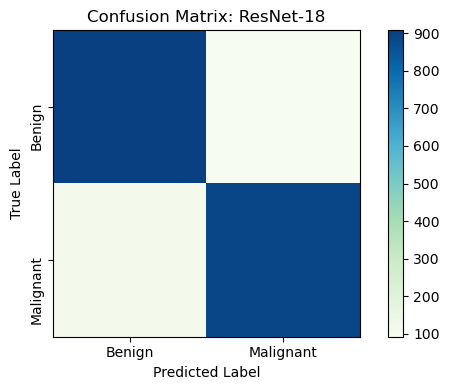

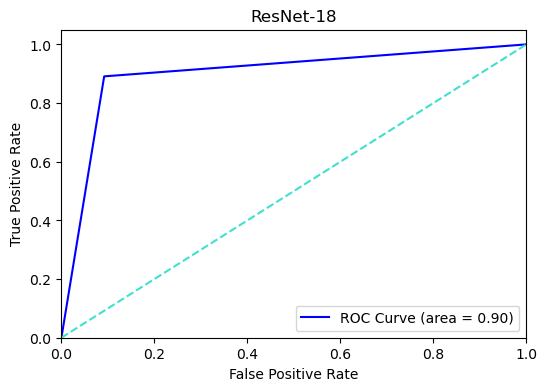

In [10]:
generate_classification_report(all_true_labels[resNet['name']], all_predictions[resNet['name']], class_names, resNet['name'])
plot_roc_curve(all_true_labels[resNet['name']], all_predictions[resNet['name']], resNet['name'])


Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.91      0.91      1000
   Malignant       0.91      0.92      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000


Confusion Matrix:
[[907  93]
 [ 80 920]]


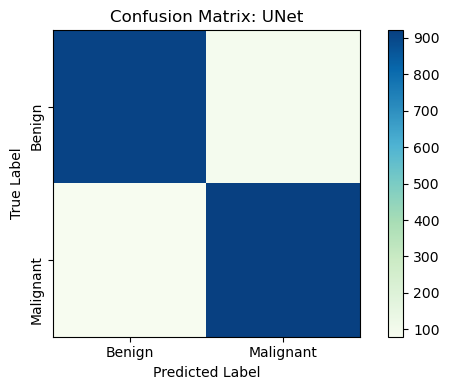

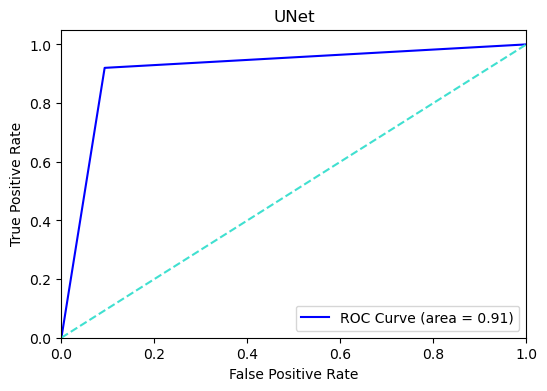

In [11]:
generate_classification_report(all_true_labels[uNet['name']], all_predictions[uNet['name']], class_names, uNet['name'])
plot_roc_curve(all_true_labels[uNet['name']], all_predictions[uNet['name']], uNet['name'])

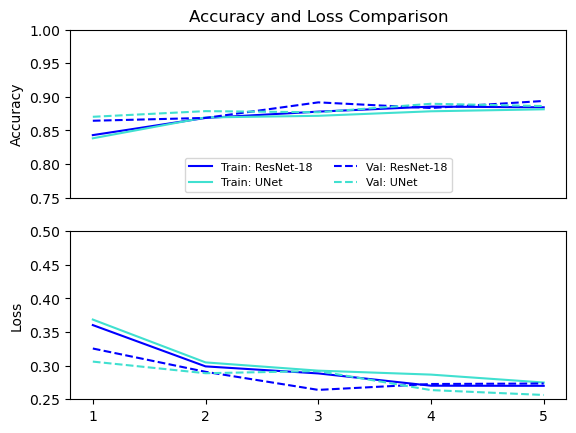

<Figure size 600x400 with 0 Axes>

In [30]:
plot_train_loss_accuracy(EPOCHS, all_train_losses, all_train_accuracies, all_val_losses, all_val_accuracies)

### Post-processing

In [31]:
def collect_images_from_loader(data_loader):
    """
    Collects and concatenates images from a given data loader.

    Args:
        data_loader (DataLoader): The PyTorch DataLoader containing the dataset.

    Returns:
        torch.Tensor: A tensor containing all images from the data loader.
    """

    images = []
    for inputs, _ in data_loader:
        images.append(inputs.cpu())

    # concatenate list of tensors to single tensor
    images = torch.cat(images) 

    return images

def visualize_misclassifications(images, true_labels, predictions, class_names, num_misclassified=10):
    """
    Visualizes misclassified images from a dataset.

    Args:
        images (torch.Tensor): Tensor containing images from the dataset.
        true_labels (list): Array of true labels for the images.
        predictions (list): Array of predicted labels for the images.
        class_names (list): List of class names corresponding to the labels.
        num_misclassified (int): Number of misclassified images to visualize.
    """
    
    true_labels_np = np.array(true_labels)
    predictions_np = np.array(predictions)
    misclassified_indices = np.where(true_labels_np != predictions_np)[0]
    
    if len(misclassified_indices) > num_misclassified:
        misclassified_indices = np.random.choice(misclassified_indices, num_misclassified, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(misclassified_indices):
        ax = plt.subplot(2, 5, i + 1)
        img = images[idx].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels_np[idx]]}\nPred: {class_names[predictions_np[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

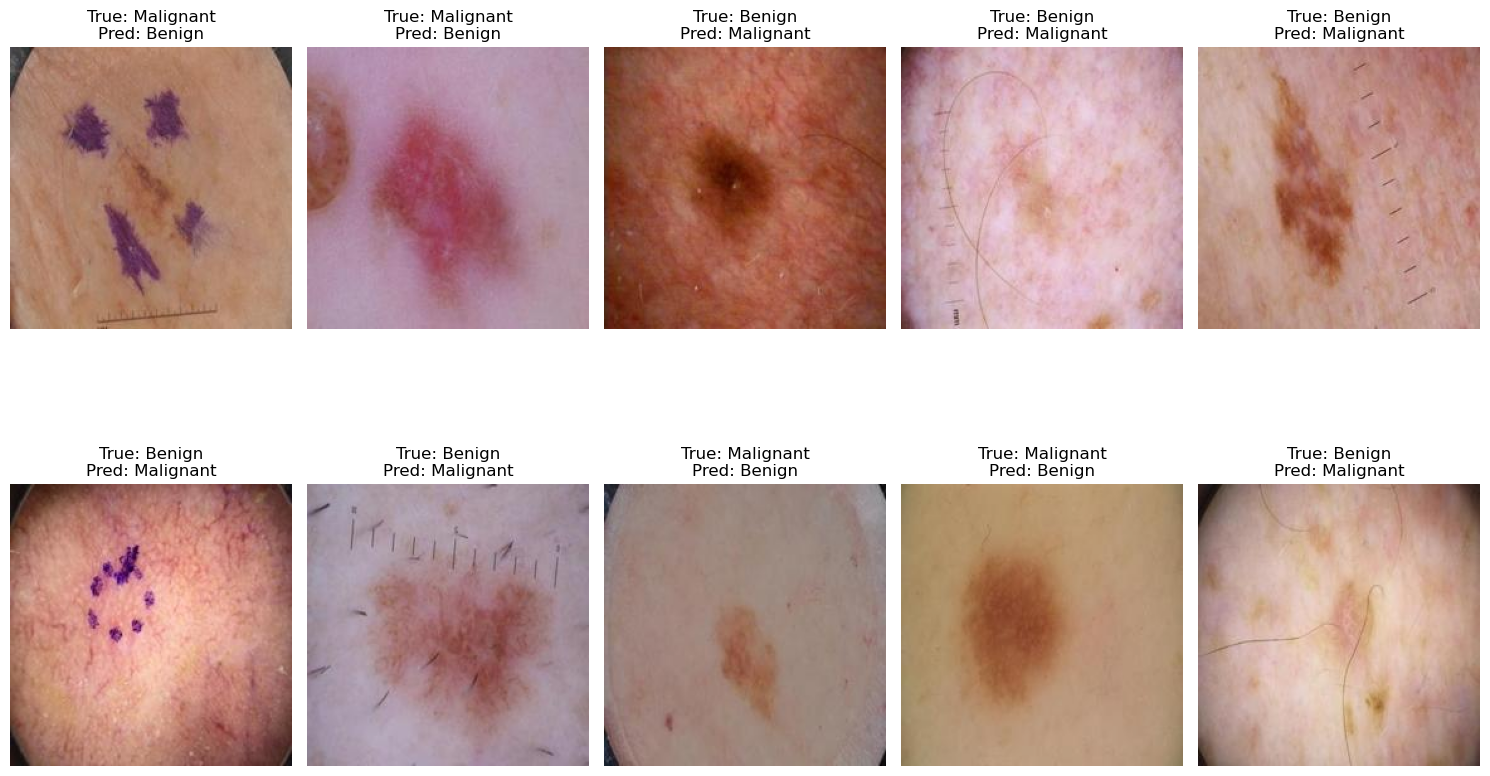

In [32]:
# collect images from test_loader
images = collect_images_from_loader(test_loader)

# visualize misclassifications
visualize_misclassifications(images, true_labels, predictions, class_names, num_misclassified=10)